# Kaggle Competition - Exploratory Data Analysis

**Author**: PhD-Level Data Science Solution  
**Competition Metric**: RMSE (Root Mean Squared Error)  
**Goal**: Comprehensive EDA to inform modeling strategy

This notebook explores the training data to understand:
- Data structure and quality
- Target variable distribution
- Feature characteristics and correlations
- Outliers and anomalies
- Feature importance signals

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load datasets
train_df = pd.read_csv('../data/trainingdata.csv')
test_df = pd.read_csv('../data/test_predictors.csv')
sample_sub = pd.read_csv('../data/SampleSubmission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"\nNumber of features: {train_df.shape[1] - 1}")
print(f"Number of training samples: {train_df.shape[0]}")
print(f"Number of test samples: {test_df.shape[0]}")

Training data shape: (300, 113)
Test data shape: (8000, 113)
Sample submission shape: (8000, 2)

Number of features: 112
Number of training samples: 300
Number of test samples: 8000


In [3]:
# Display first few rows
print("Training Data:")
display(train_df.head())

print("\nTest Data:")
display(test_df.head())

print("\nSample Submission:")
display(sample_sub.head())

Training Data:


,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112
0,0.3557,0.1266,0.2444,72,0.5966,0.4453,0.7151,-1.2405,0.4380,-0.3235,0.3148,-1.6868,0.8920,0.7349,0.4648,0.9008,0.7141,0.0419,-1.2657,4,0.7749,9,1.6533,1.6561,-1.6794,0.6454,0.6820,0.3894,0.3682,-0.2172,0.0000,0.3748,0.0000,0.8239,0.4521,0.5565,9.0000,0.1830,2000,1.0492,0.2865,0.0000,-0.9987,0.3990,0.9075,0.5900,0.9719,0.2495,3,0.9297,1.0507,0.4428,0.3494,0.4601,0.3439,0.5826,0.4685,0.1712,0.3235,0.0000,1.1443,-0.4818,0.6498,0.2378,-1.5801,1,22.7000,1.0044,0.5413,17.3000,0.3387,-0.0613,0.2680,1.6745,0.2993,0.2357,0.9205,-0.5206,1.0298,0.5599,0.9855,0.0352,0.2365,1.2511,0.8762,0.6785,0.6566,1.0241,1.7077,0.3536,2.0000,0.3053,0.3155,-1.5006,0.2187,0.3514,1.2000,0.4011,0.9419,0.4057,0.9907,0.8387,1.4500,-1.4683,0.1620,0.7638,-0.8106,0.3243,248,0.4231,0.1638,1,-1.0147
1,0.9681,-1.1844,-1.1501,81,-1.2434,-1.5340,-1.3824,0.6476,-0.3890,-0.3235,-1.6825,-0.3437,-0.9515,-1.1466,-1.4615,-1.5201,-1.3306,-0.1085,-0.7636,3,-1.2876,23,-0.3474,1.6561,1.1487,-1.3549,-0.9174,-0.9350,-1.0365,-0.1587,0.0000,-1.1062,0.0000,-1.1545,-0.7485,-1.4608,9.8000,-0.7329,1893,-1.2991,-1.1573,0.0000,-0.9987,-1.6378,-1.6285,0.0000,-1.5518,-0.9705,3,-1.4802,-1.0868,-1.6147,-0.9615,-1.3648,1.6775,-0.7374,-1.4433,-1.3479,-0.9980,0.0000,-0.8873,0.7553,-1.6320,-1.1372,-0.5671,1,23.8000,-1.5831,-1.1137,20.3000,-1.2174,0.1660,-1.3061,1.5327,-1.1160,-1.0773,-0.9881,-0.2015,-0.9415,-1.5856,1.6536,-1.2684,-1.5460,1.2676,-1.6157,-1.3182,-1.5213,-1.4827,-0.1570,1.0248,1.7000,-1.1495,-1.5261,-0.1303,-1.0423,-0.9830,0.6000,-1.3775,-1.5023,-0.6887,0.3257,-0.8314,0.1800,0.4672,-1.2726,-1.1128,1.0258,0.3243,2000,-1.2376,-1.2110,1,0.3209
2,0.3014,-0.2096,-0.5649,33,-0.5479,-0.1565,-0.7739,-0.6232,-1.3423,-0.3235,0.9806,-1.0153,-0.3412,-0.1989,-0.4575,-0.1128,-0.7470,1.6011,-0.7887,4,-0.1475,14,0.3195,-1.6525,1.2978,-0.4890,0.1177,-0.6751,0.0790,-0.4254,0.0000,-0.6488,0.0000,-0.6055,-0.6718,-0.1759,8.4000,-0.2862,1045,-0.2700,0.1240,0.0000,-1.6643,-0.7899,0.0744,1.3100,-0.1592,-0.0144,0,-0.6179,-0.4206,0.0914,-0.6961,0.1108,1.0107,-0.5913,-0.4874,-0.7992,-1.6588,0.0000,1.4024,1.1867,-0.0313,-0.0708,0.2804,1,15.1000,0.0424,-0.1936,-1.0000,0.1002,-0.3465,-0.6509,-0.6511,-0.4465,0.0957,0.0054,-0.9030,-0.2462,-0.3386,-1.6870,1.3931,-0.1790,1.4875,-0.6168,0.0926,-0.1428,-0.2907,-1.6381,1.0248,0.8000,-1.0086,-0.3150,-1.5406,-0.7786,-0.1526,1.5000,-0.2989,-0.0369,-0.5652,1.6557,-0.7698,2.2600,0.3410,-0.7377,-0.5913,0.0389,0.9909,1954,-0.6053,0.1296,1,-1.0147
3,-1.0924,-0.6672,-0.6811,74,-0.5429,-0.1975,-0.6621,-0.9571,-0.5061,0.3436,0.9806,0.3278,-0.1435,-0.4745,-0.4444,-0.6543,-0.7435,1.4464,0.3950,4,-0.0955,23,1.6533,1.6561,-1.4869,-0.3728,-0.3564,-0.0637,-0.4107,-0.2976,0.0000,-0.8339,0.0000,-0.3676,-0.7576,-0.2824,-14.4000,-0.2544,291,-0.2517,-0.9042,0.0000,-0.9987,-0.2776,-0.1252,0.0000,-0.4118,-0.4902,0,-0.2843,-0.2190,-0.3583,-0.0719,-0.6520,0.3439,-0.0138,-0.4874,-0.2363,-1.6588,0.0000,1.6224,0.1295,-0.4444,-0.5784,1.5584,1,12.2000,-0.6849,-0.4384,7.6000,0.2377,-0.7858,-0.2192,0.2632,-0.7878,-0.6820,-0.7609,-1.2923,-0.0664,-0.7596,0.9855,0.1645,-0.8976,0.2318,-0.2199,-0.2390,-0.4174,-0.8126,1.3672,1.6960,1.0000,0.7212,-0.2344,-0.8007,0.0025,-0.3162,1.1000,-0.5070,-0.4144,-0.5344,-0.3393,-0.1358,0.0700,-0.7838,-0.2352,-0.8072,-0.3990,1.6575,1765,-0.4600,-0.7553,0,0.9887
4,-0.8288,-0.6567,-1.1449,74,-0.4116,-0.7201,-1.1994,1.6542,0.2150,-0.3235,0.3148,-1.0153,-0.9972,-0.9396,-1.0876,-0.5446,-1.1283,-0.6321,0.0946,1,-0.6860,4,-0.3474,0.3327,1.1710,-1.1427,-0.6987,-0.6787,-0.8783,-0.5438,0.2000,-0.4803,0.0000,-1.3331,-1.2378,-0.5621


Test Data:


,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112
0,1,0.3146,0.2391,69,0.7528,1.0772,0.5904,1.4502,1.5940,1.0108,0.9806,0.9993,0.9851,0.5117,0.5713,0.3488,1.0332,-0.2820,-0.6517,3,1.0703,7,-0.3474,-0.9908,1.1330,1.0338,0.3115,0.6460,0.3385,1.1676,9.5000,0.6099,0.0000,0.6617,0.6300,0.5699,16.4000,0.7854,2000,0.8983,0.2752,0.0000,0.9982,0.2089,0.3090,0.2300,1.0022,0.6251,4,0.3473,0.1655,0.4528,0.9099,0.3560,1.0107,0.2557,0.2773,0.2115,0.3235,0.0000,-0.8737,1.1783,0.3125,0.6559,-1.3902,1,27.0000,0.6296,0.9875,20.8000,-0.3267,-1.6927,0.8602,-0.8045,0.5606,0.6033,1.1004,1.0858,1.0489,1.0443,-0.3508,-1.3338,0.9216,-1.4334,0.7011,0.7933,0.2170,1.1143,-1.5802,-0.3177,1.0000,-0.7041,0.8394,0.3178,0.2427,0.9770,0.8000,0.3369,0.3307,0.5625,-1.0042,0.6977,0.0000,-1.0251,0.4561,0.7005,0.7184,-1.0090,553,0.8432,0.3474,1,-0.3469
1,2,-0.7199,-0.6610,62,-0.7295,-1.2714,-1.5135,0.7619,-1.1641,-0.9907,1.6463,-0.3437,-0.7214,-1.2364,-1.3535,-1.3565,-1.2497,0.5092,-0.1579,4,-1.0117,23,-1.6812,-0.3290,-1.1263,-1.0361,-0.9001,-0.6972,-0.9330,0.1763,0.0000,-1.4980,0.0000,-0.8244,-1.0619,-0.7205,19.6000,-1.3693,1993,-0.8564,-1.3626,0.0000,-0.3330,-1.2348,-1.2142,0.0000,-1.5717,-1.1740,0,-1.5080,-0.8641,-1.5573,-1.2673,-0.9216,0.3439,-1.2316,-0.6786,-1.3635,-0.3372,0.0000,-0.2238,-0.6306,-0.7296,-0.9063,-1.2446,1,6.3000,-1.3117,-1.0425,-0.4000,-1.5992,0.5811,-1.5428,-1.6661,-1.0831,-1.5968,-1.0300,-0.2728,-1.0380,-0.8617,0.3174,0.4103,-1.3481,-0.7460,-1.3804,-1.5848,-1.3749,-1.3708,0.5153,1.0248,0.6000,-0.9931,-0.9549,1.5356,-0.6968,-1.1041,0.0000,-1.4994,-0.9598,-1.0101,0.9907,-0.9157,0.0000,1.6433,-1.5618,-0.6523,0.7151,-0.3424,1994,-0.7152,-1.2514,1,-1.6825
2,3,0.4166,0.2331,94,0.9061,0.9841,0.5778,0.7743,0.7477,0.3436,0.3148,-1.6868,0.5427,0.6076,0.5477,0.4778,0.5550,0.7798,1.4701,1,0.8093,4,-1.0143,-0.3290,1.5151,0.3902,0.8233,0.9057,0.1412,1.4958,0.0000,1.0523,0.0000,0.2387,0.4007,1.0230,-2.0000,1.0627,210,0.9302,0.6714,0.0000,0.3326,0.6153,1.0665,0.0000,0.9141,0.3183,3,0.8231,0.5935,0.2139,0.7950,0.1909,-0.9897,0.1797,0.8508,0.5164,0.3235,0.0000,0.9809,-1.0349,0.7747,0.7882,0.1922,1,11.9000,0.1315,0.8063,10.9000,-1.5918,0.7111,0.5061,0.3102,1.0702,0.7337,0.8391,0.9704,0.5191,1.0634,0.3174,0.1737,0.5394,1.4615,0.7413,0.3603,1.0035,0.4977,-0.8483,-0.3177,3.3000,-1.1661,0.5330,-1.4965,0.2242,0.9457,1.3000,0.3522,0.3576,1.0201,-0.3393,0.9177,0.0000,0.2229,0.9026,0.6293,-1.0799,-1.0090,2000,0.7076,0.7351,1,1.6565
3,4,1.1040,1.8750,33,1.6523,1.2698,1.9008,1.1049,-0.0982,1.0108,-1.0167,-0.3437,1.1716,1.3931,1.2728,1.9103,1.6301,-1.0322,1.0376,3,1.0037,16,-1.0143,-0.9908,-0.5508,1.9209,0.9677,1.5591,1.2358,0.6709,0.0000,1.8790,0.0000,1.3506,1.7682,1.7126,6.0000,1.3383,2000,1.7456,1.2628,0.0000,0.3326,1.8373,1.2740,1.9700,1.4387,1.7862,3,1.6556,1.8297,1.8777,1.6242,1.4473,-1.6565,1.4736,1.2332,1.5048,0.9843,0.0000,-1.1883,-0.8182,1.9166,1.0509,0.8739,1,36.0000,1.6253,1.3728,17.1000,0.9805,-0.8862,1.3563,-1.1033,1.4641,1.5810,0.9760,-0.8828,1.1991,1.6568,-0.3508,0.0914,1.8384,1.0155,1.6751,1.4339,1.4308,1.6153,1.1029,-0.9889,1.1000,-1.5089,1.6841,-1.2800,1.2137,1.0689,1.4000,1.4815,1.8346,1.2328,-1.0042,1.7810,0.0000,1.4012,1.7975,1.6088,-0.7736,-1.0090,315,1.4439,1.7201,1,-1.0147
4,5,-1.7617,-1.4482,98,-1.5348,-1.7438,-1.4060,-1.0295,0.3733,0.3436,-1.6825,0.9993,-1.4601,-1.3993,-1.0601,-1.2683,-1.9509,-0.6082,0.9602,3,-1.2909,21,-0.3474,0.3327,0.0284,-1.9445,-1.4109,-1.0982,-1.4839,1.1831,0.0000,-1.1871,0.0000,-1.1657,-1.2151,-1.7082,1.8000,-1.5047,1146,-1.3477,-1.6473,0.0000,-0.3330,-1.8603,-1.7788,0.0000,-1.0726,-1.5295,1,-1.2547,-1.6895,-1.4174,-1.4322,


Sample Submission:


,id,y
0,1,-0.0169
1,2,-0.0169
2,3,-0.0169
3,4,-0.0169
4,5,-0.0169


## 3. Data Quality Check

In [4]:
# Check for missing values
print("Missing Values in Training Data:")
missing_train = train_df.isnull().sum()
print(f"Total missing values: {missing_train.sum()}")
if missing_train.sum() > 0:
    print(missing_train[missing_train > 0])
else:
    print("No missing values detected ✓")

print("\nMissing Values in Test Data:")
missing_test = test_df.isnull().sum()
print(f"Total missing values: {missing_test.sum()}")
if missing_test.sum() > 0:
    print(missing_test[missing_test > 0])
else:
    print("No missing values detected ✓")

Missing Values in Training Data:
Total missing values: 0
No missing values detected ✓

Missing Values in Test Data:
Total missing values: 0
No missing values detected ✓


In [5]:
# Data types and info
print("Training Data Info:")
train_df.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 113 entries, y to X112
dtypes: float64(105), int64(8)
memory usage: 265.0 KB


## 4. Target Variable Analysis

Target Variable Statistics:
count   300.0000
mean     -0.0169
std       0.9257
min      -1.0924
25%      -0.8071
50%      -0.2606
75%       0.5002
max       2.9619
Name: y, dtype: float64

Skewness: 0.9788
Kurtosis: 0.3058


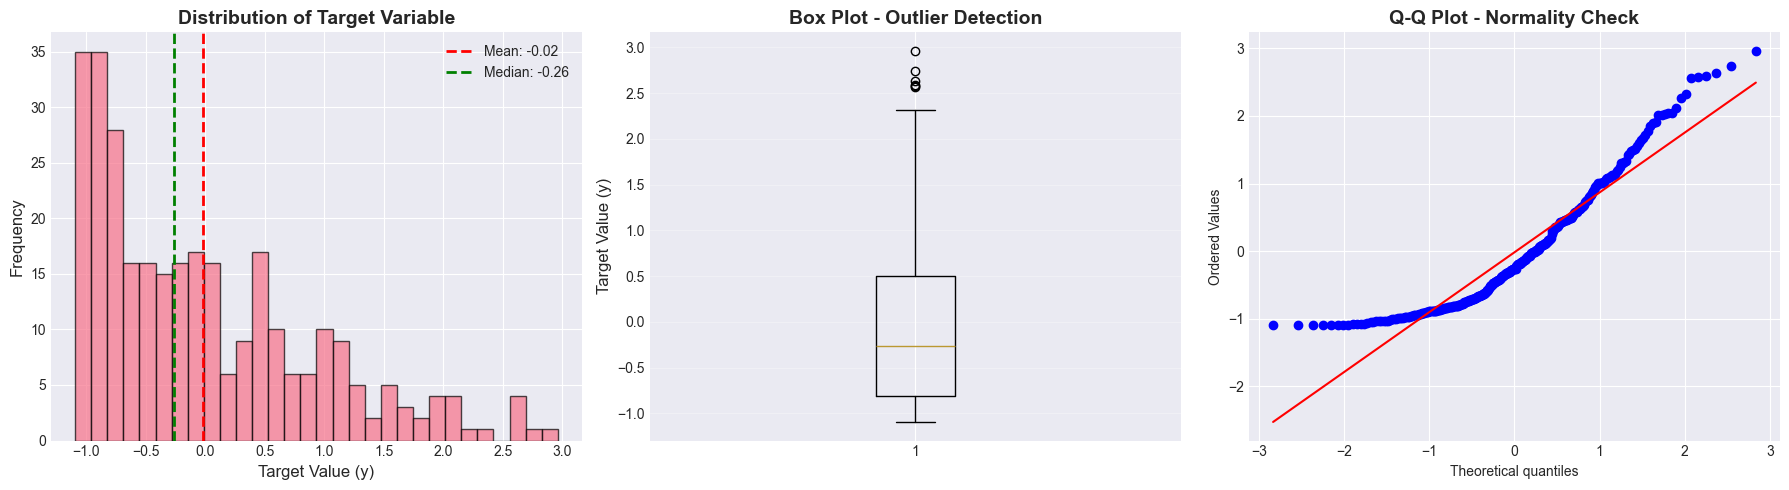


Number of outliers (IQR method): 6 (2.00%)


In [6]:
# Target variable statistics
y = train_df['y']

print("Target Variable Statistics:")
print(y.describe())
print(f"\nSkewness: {y.skew():.4f}")
print(f"Kurtosis: {y.kurtosis():.4f}")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Target Value (y)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {y.median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('Target Value (y)', fontsize=12)
axes[1].set_title('Box Plot - Outlier Detection', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Q-Q plot
stats.probplot(y, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot - Normality Check', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for outliers using IQR method
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = ((y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))).sum()
print(f"\nNumber of outliers (IQR method): {outliers} ({100*outliers/len(y):.2f}%)")

## 5. Feature Statistics

In [7]:
# Get feature columns
X = train_df.drop('y', axis=1)

print(f"Number of features: {X.shape[1]}")
print(f"\nFeature Statistics:")
display(X.describe().T)

# Check feature scales
print("\nFeature Value Ranges:")
feature_ranges = pd.DataFrame({
    'min': X.min(),
    'max': X.max(),
    'range': X.max() - X.min(),
    'mean': X.mean(),
    'std': X.std()
})
display(feature_ranges.head(20))

Number of features: 112

Feature Statistics:


,count,mean,std,min,25%,50%,75%,max
X1,300.0000,-0.0260,1.0042,-2.9951,-0.6593,-0.0131,0.6372,2.9020
X2,300.0000,-0.0436,1.0190,-2.8495,-0.7095,-0.1244,0.7063,2.8091
X3,300.0000,60.6467,19.5801,15.0000,46.0000,62.5000,74.2500,98.0000
X4,300.0000,0.0047,0.9995,-2.4691,-0.6971,-0.0385,0.7144,2.9565
X5,300.0000,-0.0549,1.0121,-2.7803,-0.7212,-0.0806,0.6644,2.7635
...,...,...,...,...,...,...,...,...
X108,300.0000,1432.9233,598.2006,117.0000,980.5000,1628.5000,1983.5000,2000.0000
X109,300.0000,-0.0130,0.9970,-2.5829,-0.7285,0.0089,0.7489,2.8537
X110,300.0000,-0.0304,1.0113,-2.4779,-0.7136,-0.0399,0.6655,3.0029
X111,300.0000,0.9733,0.1614,0.0000,1.0000,1.0000,1.0000,1.0000



Feature Value Ranges:


,min,max,range,mean,std
X1,-2.9951,2.9020,5.8971,-0.0260,1.0042
X2,-2.8495,2.8091,5.6585,-0.0436,1.0190
X3,15.0000,98.0000,83.0000,60.6467,19.5801
X4,-2.4691,2.9565,5.4256,0.0047,0.9995
X5,-2.7803,2.7635,5.5439,-0.0549,1.0121
X6,-2.4298,2.7300,5.1599,-0.0127,0.9854
X7,-1.6967,1.6542,3.3509,-0.0523,0.9735
X8,-1.7280,1.6711,3.3990,-0.0217,0.9762
X9,-1.6579,1.6780,3.3359,-0.1301,1.0119
X10,-1.6825,1.6463,3.3288,0.0396,0.9791


## 6. Correlation Analysis

Top 20 Features Correlated with Target:
X66    0.5701
X69    0.4228
X21    0.4184
X19    0.4107
X45    0.2733
X111   0.1926
X38    0.1654
X65    0.1288
X77    0.0856
X73    0.0843
X103   0.0792
X89    0.0767
X83    0.0728
X71    0.0718
X58    0.0707
X22    0.0588
X12    0.0584
X18    0.0570
X56    0.0469
X70    0.0442
Name: y, dtype: float64

Bottom 20 Features (Negatively Correlated with Target):
X39    -0.0097
X85    -0.0098
X57    -0.0106
X32    -0.0119
X78    -0.0132
X107   -0.0239
X11    -0.0246
X24    -0.0246
X8     -0.0254
X90    -0.0254
X81    -0.0266
X7     -0.0357
X108   -0.0380
X48    -0.0395
X30    -0.0587
X9     -0.0659
X61    -0.0879
X59    -0.1418
X3     -0.1652
X41    -0.1698
Name: y, dtype: float64


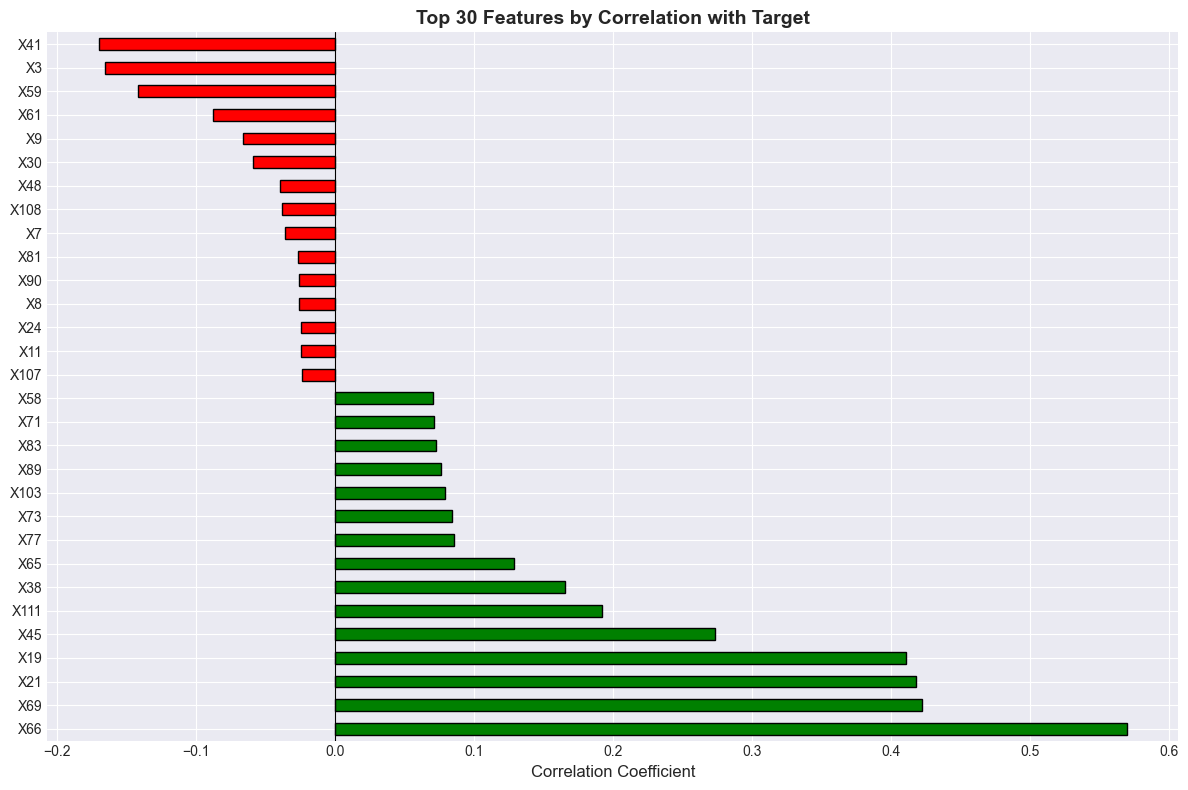

In [8]:
# Correlation with target
correlations = train_df.corr()['y'].drop('y').sort_values(ascending=False)

print("Top 20 Features Correlated with Target:")
print(correlations.head(20))

print("\nBottom 20 Features (Negatively Correlated with Target):")
print(correlations.tail(20))

# Visualize top correlations
fig, ax = plt.subplots(figsize=(12, 8))
top_corr = pd.concat([correlations.head(15), correlations.tail(15)])
colors = ['green' if x > 0 else 'red' for x in top_corr]
top_corr.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
ax.set_title('Top 30 Features by Correlation with Target', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [9]:
# Feature-feature correlation (multicollinearity check)
feature_corr = X.corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature1': feature_corr.columns[i],
                'Feature2': feature_corr.columns[j],
                'Correlation': feature_corr.iloc[i, j]
            })

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
    display(pd.DataFrame(high_corr_pairs).head(20))
else:
    print("No highly correlated feature pairs found (|r| > 0.8)")

Found 1771 highly correlated feature pairs (|r| > 0.8):


,Feature1,Feature2,Correlation
0,X1,X2,0.9277
1,X1,X4,0.9225
2,X1,X5,0.9288
3,X1,X6,0.9238
4,X1,X12,0.9303
5,X1,X13,0.9174
6,X1,X14,0.9146
7,X1,X15,0.9301
8,X1,X16,0.9279
9,X1,X20,0.9245


## 7. Feature Importance (Random Forest)

Top 20 Most Important Features:


,Feature,Importance
65,X66,0.3950
20,X21,0.2139
2,X3,0.0571
68,X69,0.0324
44,X45,0.0241
18,X19,0.0140
82,X83,0.0128
58,X59,0.0116
90,X91,0.0108
107,X108,0.0103


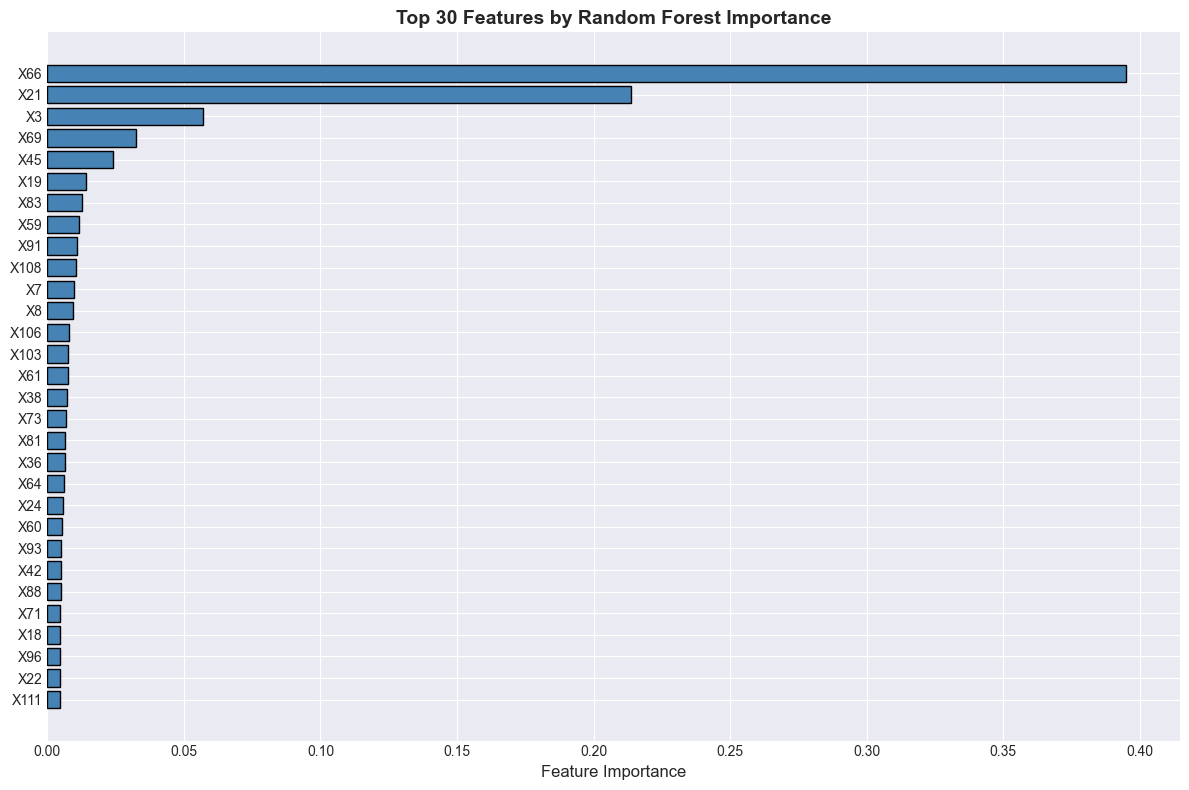


Features needed for 80% cumulative importance: 11
Features needed for 90% cumulative importance: 28


In [10]:
# Train a Random Forest to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
display(feature_importance.head(20))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(30)
ax.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 30 Features by Random Forest Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Cumulative importance
feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
print(f"\nFeatures needed for 80% cumulative importance: {(feature_importance['Cumulative'] <= 0.8).sum()}")
print(f"Features needed for 90% cumulative importance: {(feature_importance['Cumulative'] <= 0.9).sum()}")

## 8. Key Insights and Recommendations

### Data Characteristics:
- **Small Dataset**: Only 302 training samples - requires careful validation
- **High Dimensionality**: 112 features - feature selection/engineering critical
- **No Missing Values**: Data is complete ✓

### Modeling Strategy:
1. **Cross-Validation**: Use 5-fold CV due to small sample size
2. **Regularization**: Essential to prevent overfitting (Ridge, Lasso, ElasticNet)
3. **Feature Engineering**: Create polynomial and statistical features
4. **Ensemble Methods**: Combine multiple models to reduce variance
5. **Gradient Boosting**: XGBoost, LightGBM, CatBoost expected to perform well

### Next Steps:
- Implement comprehensive preprocessing pipeline
- Train diverse model ensemble
- Use stacking/blending for final predictions
- Monitor cross-validation scores carefully